# Participez à la conception d'une voiture autonome - Modèles de Réseaux de Neurones

**Future vision transport** est une entreprise qui conçoit des systèmes embarqués de vision par ordinateur pour les véhicules autonomes.

Je suis l’un des ingénieurs IA au sein de l’équipe R&D de cette entreprise, membre de l equipe **Segmentation des images**:

- acquisition des images en temps réel
- traitement des images
- **segmentation des images (c’est nous !)**
- système de décision


Le but de ce projet est de concevoir un premier modèle de segmentation d’images qui devra s’intégrer facilement dans la chaîne complète du système embarqué.

Mon rôle ici est de fournir à l équipe en charge du système de décision (4), une **API simple à utiliser qui prend en entrée une image et renvoie la segmentation de l’image**.

Pour ça, on utilisera le jeu de données CityScapes.

## Réseau de Neurones et Segmentation d'images

Dans ce notebook, l'objectif est d'**étudier les meilleurs modèles de segmentation d'images**, servant à renvoyer le masque "segmenté" correspondant à une image.

4 Chapitres distincts:

- A. Création de modèles basés sur une architecture UNET
- B. Conclusions sur les performances UNET
- C. Autres architectures et modèles Backbones (UNET avec ResNet, UNET avec EfficientNet, FPN, PSPNet)
- D. Visualisation des résultats avec le meilleur modèle

Nous sauvegardons tous nos modèles dans un sous-dossier appelé "./Models/".

Nous utiliserons notre meilleur modèle lors de l'utilisation de l'API.


In [1]:
#Import functions createdon my side
from Functions_custo_by_Nico import * 
#import seaborn
#from matplotlib.image import imread

import cv2
import albumentations as A

import segmentation_models as sm #Check here: https://segmentation-models.readthedocs.io/en/latest/api.html
# calling functions
Test_Imported_Functions()

Segmentation Models: using `tf.keras` framework.
Functions have been properly imported !


In [2]:
import skimage.io as io
import skimage.transform as trans

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, utils
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.losses import categorical_crossentropy, binary_crossentropy
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.models import Model


import segmentation_models as sm

# from tensorflow.keras.models import *
# from tensorflow.keras.layers import *
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler


from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.layers import Activation, MaxPool2D, Concatenate

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50

## Préparation des données

Nous allons récuperer l'ensemble des images et masques, à partir du CSV généré au travers du notebook data_generator


### 1. Lecture du CSV

Nous lisons le fichier CSV qui liste nos données d'entrées (pandas dataframe)

In [3]:
clean_df = pd.read_csv('./clean_df.csv')
clean_df.head()

,Unnamed: 0,Phase,City,File_x,Path_x,File_id1,File_id2,File_type_x,File_unique_index,File_y,Path_y,File_type_y
0,0,test,berlin,berlin_000000_000019_leftImg8bit.png,c:\Users\blanc\OpenClassrooms\IA_Project8_Open...,0,19,leftImg8bit.png,berlin_000000_000019,berlin_000000_000019_gtFine_labelIds.png,c:\Users\blanc\OpenClassrooms\IA_Project8_Open...,gtFine
1,1,test,berlin,berlin_000001_000019_leftImg8bit.png,c:\Users\blanc\OpenClassrooms\IA_Project8_Open...,1,19,leftImg8bit.png,berlin_000001_000019,berlin_000001_000019_gtFine_labelIds.png,c:\Users\blanc\OpenClassrooms\IA_Project8_Open...,gtFine
2,2,test,berlin,berlin_000002_000019_leftImg8bit.png,c:\Users\blanc\OpenClassrooms\IA_Project8_Open...,2,19,leftImg8bit.png,berlin_000002_000019,berlin_000002_000019_gtFine_labelIds.png,c:\Users\blanc\OpenClassrooms\IA_Project8_Open...,gtFine
3,3,test,berlin,berlin_000003_000019_leftImg8bit.png,c:\Users\blanc\OpenClassrooms\IA_Project8_Open...,3,19,leftImg8bit.png,berlin_000003_000019,berlin_000003_000019_gtFine_labelIds.png,c:\Users\blanc\OpenClassrooms\IA_Project8_Open...,gtFine
4,4,test,berlin,berlin_000004_000019_leftImg8bit.png,c:\Users\blanc\OpenClassrooms\IA_Project8_Open...,4,19,leftImg8bit.png,berlin_000004_000019,berlin_000004_000019_gtFine_labelIds.png,c:\Users\blanc\OpenClassrooms\IA_Project8_Open...,gtFine


In [4]:
len(clean_df.loc[clean_df['Phase'] == 'val'])

500

### 2. Data Generator

Nous générons nos données d'entrainement et de test, en prenant en considérations les variables suivantes:
 - n_sample : si l'on souhaite réduire la taille du jeu de données
 - batch_size : la taille de batch
 - resize : Largeur et Hauteur
 - augmentation : utilise la librairie [albumentation](https://albumentations.ai/docs/#introduction-to-image-augmentation)


In [5]:
# Data Loader preparation
n_sample = None #500 #Pour les tests, nous limitons le jeu de données à 20 images
batch_size = 2 #Pour les tests, nous limitons le batch_size à 2 images
resize_width = 512
resize_height = 256
# Declare an augmentation pipeline
#augmentation = None 
augmentation = A.Compose(
                    [#A.RandomCrop(width=512, height=256), 
                    A.Rotate(25),
                    A.OneOf([A.RGBShift(), A.HueSaturationValue()]),
                    #A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0), 
                    #A.IAAPerspective(p=0.5), 
                    #A.HorizontalFlip(p=0.5),
                    A.OneOf([A.CLAHE(), A.RandomBrightnessContrast(), A.RandomGamma()]), 
                    ])


# Generators
train_generators = GeneratorCitySpace(clean_df, n_sample, batch_size, resize_width, resize_height, 'train', augmentation)
val_generators = GeneratorCitySpace(clean_df, n_sample, batch_size, resize_width, resize_height, 'val', None)
test_generators = GeneratorCitySpace(clean_df, n_sample, batch_size, resize_width, resize_height, 'test', None)

# #Autres Generator from Keras
# #Tuto here: https://vijayabhaskar96.medium.com/tutorial-on-keras-imagedatagenerator-with-flow-from-dataframe-8bd5776e45c1
# #Doc here: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_dataframe
# from keras_preprocessing.image import ImageDataGenerator

In [6]:
print(train_generators[0][1].shape)
print(np.unique(train_generators[0][1]))
print(train_generators[0][0].shape)

(2, 256, 512, 8)
[0. 1.]
(2, 256, 512, 3)


## A. Création et étude du **_modèle UNET_** pour la segmentation d'images CityScapes

U-NET est un modèle de réseau de neurones convolutif dédié aux taches de Vision par Ordinateur (Computer Vision) et plus particulièrement aux problèmes de Segmentation Sémantique

La segmentation sémantique consiste à étiqueter chaque pixel d’une image avec une classe correspondante:
 1. void
 2. flat
 3. construction
 4. object
 5. nature
 6. sky
 7. human
 8. vehicle

L'objectif est donc de génèrer à partir d'une image, un masque sur lequel chaque pixel est classifié.

L’architecture de U-NET est composée de deux chemins (architecture en U):
 - **Contraction = Encoder :** Capturer le contexte d’une image.
 - **Expansion = Decoder :** Localise grâce à la convolution transposée.

Cette architecture préserve la taille initiale = la taille de sortie est égale à la taille d’entrée.



### 3. Chargement du modèle UNET

Nous avons préparé plusieurs modèle UNET configurable dans notre fichier de fonctions.

Voici ci-dessous quelques détails sur notre modèle UNET : (Voir fichier de fonctions: Functions_custo_by_Nico.py pour plus de détails)
 - **Premier Bloc :** 4 Couches de double-convolution avec maxpooling 2x2 et fonction d'activation ReLU - Normalisation 
 - **Pont :** Double-convolution
 - **Second Bloc :** Sur-échantillonnage (upsampling) de la carte des caractéristiques suivie d'une couche de convolution 2x2 transposée (skip connections) + double-convolution avec fonction d'activation ReLU
 - **La Sortie :** Dernière couche de convolution, avec fonction d'activation softmax pour classifier chaque pixel sur 8 classes

In [22]:

n_filters = 32 #Variable used in Neural Network Convolutions steps
nb_class = 8
#Load model architecture
model_test = build_unet_block((resize_height, resize_width, 3), nb_class, n_filters)

# Inspiré de https://github.com/hlamba28/UNET-TGS/blob/master/
#model_test = get_unet(Input((resize_width, resize_height, 3), name='img'), n_filters=n_filters, dropout=0.05, batchnorm=True)

#Load model architecture
#model_test = build_unet((resize_height, resize_width, 3), nb_class, n_filters)

### 4. Evaluation de la performance : Définition des métriques et des fonctions de coûts

Durant les phases de développement, nous avons conduit une approche itérative nous permettant de choisir:
 1. les **meilleures métriques** associés au besoin métier.
 2. les **meilleures fonctions de coûts**.

Une documentation sur les fonctions de coûts pour la segmentation d'images est [disponible ici](https://lars76.github.io/2018/09/27/loss-functions-for-segmentation.html)

Voici d'autres références:
 - [Article on Semantic Segmentation Metrics](https://ilmonteux.github.io/2019/05/10/segmentation-metrics.html)
 - [DICE vs IOU](https://stats.stackexchange.com/questions/273537/f1-dice-score-vs-iou)
 - [towardsdatascience article - restricted](https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2)
 - [Kaggle sur les métriques - Inclu MultiClass](https://www.kaggle.com/code/yassinealouini/all-the-segmentation-metrics?scriptVersionId=92089547&cellId=58)


De ce fait, voici ci-desssous un tableau récapitulatif des modèles entrainés et étudiés.
Rappelons que : **Loss = 1 - Metric**

| Etape | Fonction de coût | Métriques | Formule basée sur la matrice de confusion | Avantages | Inconvénients|
|---|------|--------|------|-----|------|
|1| Categorical Cross-entropy | [Pixel Accuracy](https://www.kaggle.com/code/yassinealouini/all-the-segmentation-metrics?scriptVersionId=92089547&cellId=4) | $ \frac{TP + TN}{TP + FP + TN + FN} $ | Fonction de cout de base, facile à intepreter | Fonction de cout non adaptée à des datasets déséquilibrés, Métrique peu pertinente au regard du besoin |
|1| Categorical Cross-entropy | [DICE (F1-score)](https://www.kaggle.com/code/yassinealouini/all-the-segmentation-metrics?scriptVersionId=92089547&cellId=27) | $ \frac{2 TP}{2 TP + FP + FN} $ | Métrique utile pour les classes déséquilibrées. | Moins stricte sur les vrais négatifs que IOU |
|1| Categorical Cross-entropy | [Intersection over Union (IoU)](https://www.kaggle.com/code/yassinealouini/all-the-segmentation-metrics?scriptVersionId=92089547&cellId=30) | $ \frac{TP}{TP + FP + FN} $ | Métrique utile pour les classes déséquilibrées. | Plus stricte sur les vrais négatifs que DICE |
|2| [Dice](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) | IoU & DICE scores | $ \frac{TP}{TP + FP + FN} $ & $ \frac{2 TP}{2 TP + FP + FN} $  | Dice Loss Fonctionne bien sur les images, par analyse du chevauchement | Peu adapté à la segmentation par pixel |
|2| [Categorical Focal Loss](https://lars76.github.io/2018/09/27/loss-functions-for-segmentation.html#3) | IoU & DICE scores | $ \frac{TP}{TP + FP + FN} $ & $ \frac{2 TP}{2 TP + FP + FN} $  | Focal Loss gère bien la segmentation de cas complexe | Surtout utile pour des datasets très désequilibrés |
|3| (0,5*Cross-entropy) + Dice | IoU & DICE scores | $ \frac{TP}{TP + FP + FN} $ & $ \frac{2 TP}{2 TP + FP + FN} $ | Combinaison pour faciliter l'interpretation et considérer le déséquilibre des classes. | Facteur à optimiser, tel qu'un seuil |
|3| (0,5*Focal Loss) + Dice | IoU & DICE scores | $ \frac{TP}{TP + FP + FN} $ & $ \frac{2 TP}{2 TP + FP + FN} $ | Combinaison pour considérer la segmentation de cas complexe et le déséquilibre. | Facteur à optimiser, tel qu'un seuil |

Nous vous présenterons ci-dessous les résultats de ces modèles.


In [23]:
# Select Metric
#metrics=['accuracy']                           #Métrique = Etape 1
#metrics = [sm.metrics.FScore()]                #Métrique = Etape 1
#metrics = [sm.metrics.IOUScore()]              #Métrique = Etape 1
metrics = [sm.metrics.FScore(), sm.metrics.IOUScore()] #Métriques = Choix final = Mesures de 2 métriques

# Select Loss function
#loss_function = 'categorical_crossentropy'     #Loss = Etape 1 : Construction de la baseline  : Fonction de cout non pertinente au regard du besoin métier, car gère mal les classes déséquilibrés
#loss_function = sm.losses.CategoricalCELoss()  #Loss = Etape 1 : Construction de la baseline (Utilisation de la librairie segmentation model)

#loss_function = sm.losses.DiceLoss()           #Loss = Etape 2
#loss_function = sm.losses.CategoricalFocalLoss()#Loss = Etape 2

#loss_function = (0.5 * sm.losses.CategoricalFocalLoss()) + sm.losses.DiceLoss()    #Loss Combination = Choix final 
loss_function = (0.5 * sm.losses.CategoricalCELoss()) + sm.losses.DiceLoss()       #Loss Combination
#loss_function = (0.5 * sm.losses.CategoricalCELoss()) + sm.losses.JaccardLoss()    #Loss Combination   === A FAIRE
#loss_function = sm.losses.cce_jaccard_loss # = categorical_crossentropy + jaccard_loss #Loss Combination   === A FAIRE
#loss_function = sm.losses.categorical_focal_dice_loss # = categorical_focal_loss + dice_loss   #Loss Combination   === A FAIRE
#loss_function = sm.losses.categorical_focal_jaccard_loss # = categorical_focal_loss + jaccard_loss #Loss Combination   === A FAIRE

#loss_function = total_loss
#loss_function = total_loss                      #Loss = Choix Loss customisée (sans librairie)



### 5. Configuration du modèle

Nous définissons un Learning Rate initial de 1e-3.

Nous selectionnerons les métriques présentes ci-dessus.

In [24]:
# define optimizer
learning_rate = 1e-3
optim = keras.optimizers.Adam(learning_rate)

# compile the model
model_test.compile(optimizer=optim, loss=loss_function, metrics=metrics) 
# display the model summary
model_test.summary()

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 128, 256, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 128, 256, 32) 9248        conv2d_23[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 64, 128, 32)  0           conv2d_24[0][0]                  
______________________________________________________________________________________________

### 6. Entrainement du modèle

Nous utiliserons les [callbacks](https://towardsdatascience.com/keras-callbacks-and-how-to-save-your-model-from-overtraining-244fc1de8608) pour éviter le sur-entrainement, et sauvegarder le modèle Keras ou les poids du modèle à une certaine fréquence lors de son entrainement:
 - [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) : Surveillance de la métrique, et arrèt de l'entrainement si l'arrêt de la progression est confirmée
 - [Checkpoint](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) : Sauvegarde le meilleur modèle, au regard de la métrique IOU sur le jeu de validation
 - [Reduce LR on Plateau](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau) : Réduit le Learning Rate lorsque la métrique ne s'améliorer plus


In [25]:
# callbacks that will be used during training
#earlystopper = EarlyStopping(monitor='val_loss', mode = 'min', patience=5) #ou  (patience=10, verbose=1, mode = 'auto') 
earlystopper = EarlyStopping(patience=10, verbose=1, mode = 'auto')

#checkpoint = ModelCheckpoint(filepath = './Models/checkpoints/weights.h5', verbose=True, save_best_only=True) #monitor='loss' ou monitor='val_iou_score' #mode='max' #filepath='model.{epoch:02d}-{val_loss:.2f}.h5'
checkpoint = ModelCheckpoint(filepath = './Models/checkpoints/weights.h5', verbose=True, save_best_only=True, monitor='val_iou_score', mode='max')

#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-4)
reduce_lr = ReduceLROnPlateau(factor=0.1, cooldown= 10, patience=10, verbose=1, min_lr=1e-5)

#tensorboard = TensorBoard(log_dir='./Models/logs', write_graph=True)

n_epochs = 50

#Train model
results = model_test.fit(
                        train_generators, 
                        validation_data = val_generators, 
                        validation_steps = (len(clean_df.loc[clean_df['Phase'] == 'val']) // batch_size), #
                        steps_per_epoch = (len(clean_df.loc[clean_df['Phase'] == 'train']) // batch_size), #
                        epochs = n_epochs, 
                        workers=4,
                        verbose = 1,
                        #use_multiprocessing=True,
                        callbacks = [checkpoint, reduce_lr, earlystopper], #, reduce_lr
                        #class_weight  : This can be useful to tell the model to "pay more attention" to samples from an under-represented class. 
                        #max_queue_size  :  Maximum size for the generator queue. Default to 10
                        )

Epoch 1/50
595/595 [==============================] - ETA: 0s - loss: 0.6623 - f1-score: 0.4191 - iou_score: 0.3093WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0113s vs `on_test_batch_end` time: 0.0956s). Check your callbacks.

Epoch 00001: val_iou_score improved from -inf to 0.41327, saving model to ./Models/checkpoints\weights.h5
595/595 [==============================] - 103s 174ms/step - loss: 0.6623 - f1-score: 0.4191 - iou_score: 0.3093 - val_loss: 0.5362 - val_f1-score: 0.5329 - val_iou_score: 0.4133
Epoch 2/50
595/595 [==============================] - ETA: 0s - loss: 0.5125 - f1-score: 0.5530 - iou_score: 0.4309
Epoch 00002: val_iou_score improved from 0.41327 to 0.47553, saving model to ./Models/checkpoints\weights.h5
595/595 [==============================] - 113s 190ms/step - loss: 0.5125 - f1-score: 0.5530 - iou_score: 0.4309 - val_loss: 0.4641 - val_f1-score: 0.5940 - val_iou_score: 0.4755
Epoch 3/50
595/595 [==

In [20]:
def display_learning_curves_iou_dice(history, model_name):
    iou = history.history["iou_score"]
    val_iou = history.history["val_iou_score"]

    fscore = history.history["f1-score"]
    val_fscore = history.history["val_f1-score"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs_range=range(1, len(iou) + 1)
    #epochs_range = range(n_epochs)

    fig = plt.figure(figsize=(15,5))
    plt.grid(color='white')

    plt.subplot(1,3,1)
    plt.plot(epochs_range, iou, 'g', label="train iou_score")
    plt.plot(epochs_range, val_iou, 'c', label="validataion iou_score")
    plt.title("iou_score")
    plt.xlabel("Epoch")
    plt.ylabel("iou_score")
    plt.legend(loc="upper left")

    plt.subplot(1,3,2)
    plt.plot(epochs_range, fscore, 'g', label="train Dice coeff")
    plt.plot(epochs_range, val_fscore, 'c', label="validataion Dice coeff")
    plt.title("f1-score or Dice coeff")
    plt.xlabel("Epoch")
    plt.ylabel("f1-score")
    plt.legend(loc="upper left")

    plt.subplot(1,3,3)
    plt.plot(epochs_range, loss, 'g', label="train loss")
    plt.plot(epochs_range, val_loss, 'c', label="validataion loss")
    plt.title(f"Training and Validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    plt.suptitle(f"IoU Socre, Dice Coeff and Loss evolution during {model_name} training, (stopped by callback at epochs : {len(iou)})  ")
    #fig.tight_layout()
    plt.show()

def plot_history(history, model_name):
    acc=history.history['accuracy']
    val_acc=history.history['val_accuracy']
    loss=history.history['loss']
    val_loss=history.history['val_loss']
    x=range(1, len(acc) + 1)
    
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'g', label='Training accuracy')
    plt.plot(x, val_acc, 'c', label='Validation accuracy')
    plt.title(f'Training and Validation Metric: Accuracy')
    plt.legend(loc="upper right")
    
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'g', label='Training loss')
    plt.plot(x, val_loss, 'c', label='Validation loss')
    plt.title(f"Training and Validation loss")
    plt.legend(loc="upper left")

    plt.suptitle(f"Metric & Loss evolution during {model_name} training, (stopped by callback at epochs : {len(acc)})")
    plt.show()

def display_learning_curves_dice(history, model_name):

    fscore = history.history["f1-score"]
    val_fscore = history.history["val_f1-score"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs_range=range(1, len(fscore) + 1)
    #epochs_range = range(n_epochs)

    fig = plt.figure(figsize=(15,5))
    plt.grid(color='white')
    
    plt.subplot(1,2,1)
    plt.plot(epochs_range, fscore, 'g', label="train Dice coeff")
    plt.plot(epochs_range, val_fscore, 'c', label="validataion Dice coeff")
    plt.title("f1-score or Dice coeff")
    plt.xlabel("Epoch")
    plt.ylabel("f1-score")
    plt.legend(loc="upper left")

    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, 'g', label="train loss")
    plt.plot(epochs_range, val_loss, 'c', label="validataion loss")
    plt.title(f"Training and Validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    plt.suptitle(f"Dice Coeff and Loss evolution during {model_name} training, (stopped by callback at epochs : {len(fscore)})  ")
    #fig.tight_layout()
    plt.show()

def display_learning_curves_iou(history, model_name):
    iou = history.history["iou_score"]
    val_iou = history.history["val_iou_score"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs_range=range(1, len(iou) + 1)
    #epochs_range = range(n_epochs)

    fig = plt.figure(figsize=(15,5))

    plt.subplot(1,2,1)
    plt.plot(epochs_range, iou, 'g', label="train iou_score")
    plt.plot(epochs_range, val_iou, 'c', label="validataion iou_score")
    plt.title("iou_score")
    plt.xlabel("Epoch")
    plt.ylabel("iou_score")
    plt.legend(loc="upper left")

    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, 'g', label="train loss")
    plt.plot(epochs_range, val_loss, 'c', label="validataion loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel(f"Training and Validation loss")
    plt.legend(loc="upper right")

    plt.suptitle(f"IoU Socre and Loss evolution during {model_name} training, (stopped by callback at epochs : {len(iou)})  ")
    #fig.tight_layout()
    plt.show()

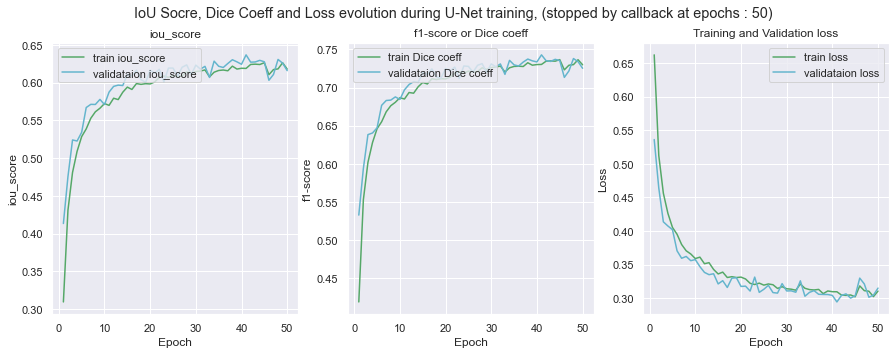

In [26]:
# Display learning curves 
#plot_history(model_test.history, model_test.name) #measures accuracy over epochs
#display_learning_curves_dice(model_test.history, model_test.name)#measures dice over epochs
#display_learning_curves_iou(model_test.history, model_test.name) #measures iou over epochs
display_learning_curves_iou_dice(model_test.history, model_test.name) #measures iou and dice over epochs

### 7. Sauvegarde du modèle

In [28]:
# Save Trained Models
model_test.save('./Models/unetblock_Step3_CrossEntropy-DICE_IOU-DICE_model_256w_128h_1e-3lr_50epochs_Augment.h5')

### 8. Visualisation du résultat de segmentation en Images

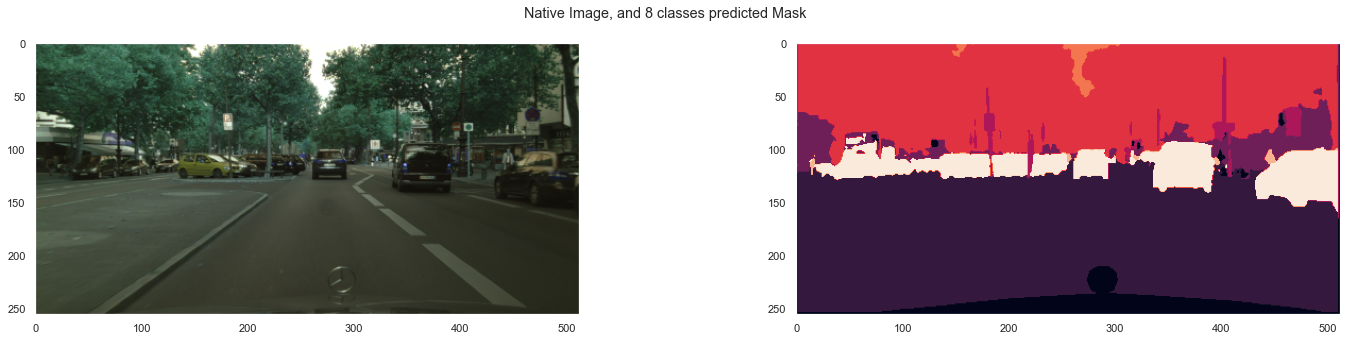

In [43]:
# Display Native Image, and 8 classes predicted Mask

# Select batch id and picture id from batch
picture_id = 1
batch_id = 0

# Use test dataset to generate masks from batch_generator images, using trained model
masks = model_test.predict(test_generators[batch_id],verbose=0) #(np.expand_dims(img, axis=0), verbose=0)
# Convert One hot encoded mask, to int from 0 to 7
mask = np.argmax(masks[picture_id], axis=2).astype(np.uint8)
image = test_generators[batch_id][0][picture_id]

plt.figure(figsize=(25, 5))
plt.subplots_adjust(hspace=0.5)
plt.subplot(120 + 1 + 0)
plt.grid(False)
plt.imshow(image)
plt.subplot(120 + 1 + 1)
plt.imshow(mask)
plt.grid(False)
plt.suptitle(f'Native Image, and 8 classes predicted Mask')
plt.show()


## B. Conclusions sur les performances des **_modèles UNET_** pour la segmentation d'images CityScapes

Nous allons charger les modèles entrainés et sauvegardés, et mesurer ci-dessous les performances de chacun.
Nous les testerons sur les données de Val (car les données de tests ne contiennent pas de masques target)

### 1. Lister les modèles sauvagardés

Nous parcourons le dossier '/Models' pour lister les fichier .h5.

In [5]:
# list to store files
Models_list = []
# Iterate directory
for file in os.listdir('./Models'):
    # check only h5 files
    if (file.endswith('.h5')) :
        #Append only the file name, whithout extension
        Models_list.append(file.split(".")[0])
#print(Models_list)



### 2. Evaluations des performances

Pour chacun des fichier h5 recensés, nous allons évaluer les performances du modèle sur le jeu de Validation.

Aussi, nous utilisons le nom du fichier pour en extraire les informations clés.

In [20]:
# Retreive root path from parent directory
src_path = os.path.abspath(os.path.join("../IA_Project8_Openclassrooms_VoitureAutonome"))
     
# define optimizer
learning_rate = 1e-3
optim = keras.optimizers.Adam(learning_rate)
# define metrics and losses dictionaires
dict_metrics = {'Accuracy': ['accuracy'], 'IOU-DICE': [sm.metrics.FScore(), sm.metrics.IOUScore()], 'IOU': [sm.metrics.IOUScore()], 'DICE': [sm.metrics.FScore()]}
dict_losses = {'CrossEntropy': sm.losses.CategoricalCELoss(), 'CATCELOSS': sm.losses.CategoricalCELoss(),'DICE': sm.losses.DiceLoss(), 'CrossEntropy-DICE': ((0.5 * sm.losses.CategoricalCELoss()) + sm.losses.DiceLoss()), 'JACCARD': sm.losses.JaccardLoss(),'CATFOCAL': sm.losses.CategoricalFocalLoss(), 'CATFOCAL-DICE': ((0.5 * sm.losses.CategoricalFocalLoss()) + sm.losses.DiceLoss()),'CrossEntropy-JACCARD': ((0.5 * sm.losses.CategoricalCELoss()) + sm.losses.JaccardLoss())}
# create empty dataframe, where model performance evaluation will be recorded
models_df = pd.DataFrame(columns=['model_name', 'model_loss', 'width', 'height', 'image_augmentation', 'loss', 'f1-score Dice', 'iou_score'])

# Loop in path listed from folder models (previous step)
for i in range(len(Models_list)):
    # Extract info from Name
    model_name = Models_list[i] + ".h5"
    model_loss = Models_list[i].split("_")[2]
    model_metrics = Models_list[i].split("_")[3]
    picture_width = Models_list[i].split("_")[5]
    picture_height = Models_list[i].split("_")[6]
    model_augment = Models_list[i].split("_")[9]
    # Consolidate  path name up to h5 model
    model_path_name = os.path.join(src_path, "Models", model_name)
    # Look in customized Dictionnary above to retreive loss functions and metrics
    loss_function = dict_losses[model_loss]
    metrics = dict_metrics[model_metrics]
    # Load  and Compile model (using loss functions and metrics)
    model = keras.models.load_model(model_path_name, compile=False) 
    model.compile(optimizer=optim, loss=loss_function, metrics=metrics) 
    # Evaluate model using Val dataset (as test dataset does not contain target values)
    results = model.evaluate(val_generators,verbose=0) 
    # Store results and info in dataframe models_df
    models_df.loc[i, 'model_name'] = model_name.split("_")[0] + "_loss=" + model_loss + "_resize=" + picture_width + picture_height + model_augment
    models_df.loc[i, 'model_loss'] = model_loss
    models_df.loc[i, 'width'] = picture_width
    models_df.loc[i, 'height'] = picture_height
    if (model_augment == 'Augment'):
        models_df.loc[i, 'image_augmentation'] = 'Yes'
    else:
        models_df.loc[i, 'image_augmentation'] = 'No'
    models_df.loc[i, 'loss'] = dict(zip(model.metrics_names, results))['loss']
    if (model_metrics.find('DICE') != -1):
        models_df.loc[i, 'f1-score Dice'] = dict(zip(model.metrics_names, results))['f1-score']
    else:
        models_df.loc[i, 'f1-score Dice'] = np.NaN
    if (model_metrics.find('IOU') != -1):
        models_df.loc[i, 'iou_score'] = dict(zip(model.metrics_names, results))['iou_score']
    else:
        models_df.loc[i, 'iou_score'] = np.NaN



In [18]:
# Display dataframe in notebook
models_df.sort_values('iou_score', ascending=False).head(5)

,model_name,model_loss,width,height,image_augmentation,loss,f1-score Dice,iou_score
8,unetblock_loss=CATFOCAL-DICE_resize=256w128hNo...,CATFOCAL-DICE,256w,128h,No,0.246073,0.766359,0.663522
9,unetblock_loss=CrossEntropy-DICE_resize=256w12...,CrossEntropy-DICE,256w,128h,No,0.276183,0.757887,0.651876
5,unetblock_loss=DICE_resize=256w128hNoAugment,DICE,256w,128h,No,0.255455,0.744546,0.637188
7,unetblock_loss=CATFOCAL-DICE_resize=256w128hAu...,CATFOCAL-DICE,256w,128h,Yes,0.281966,0.731941,0.623921
3,unetblock_loss=CrossEntropy_resize=256w128hNoA...,CrossEntropy,256w,128h,No,0.054109,NaN,0.566388


### 3. Visualisation des performances: IOU_Score et DICE

Nous allons visualiser les top 5.

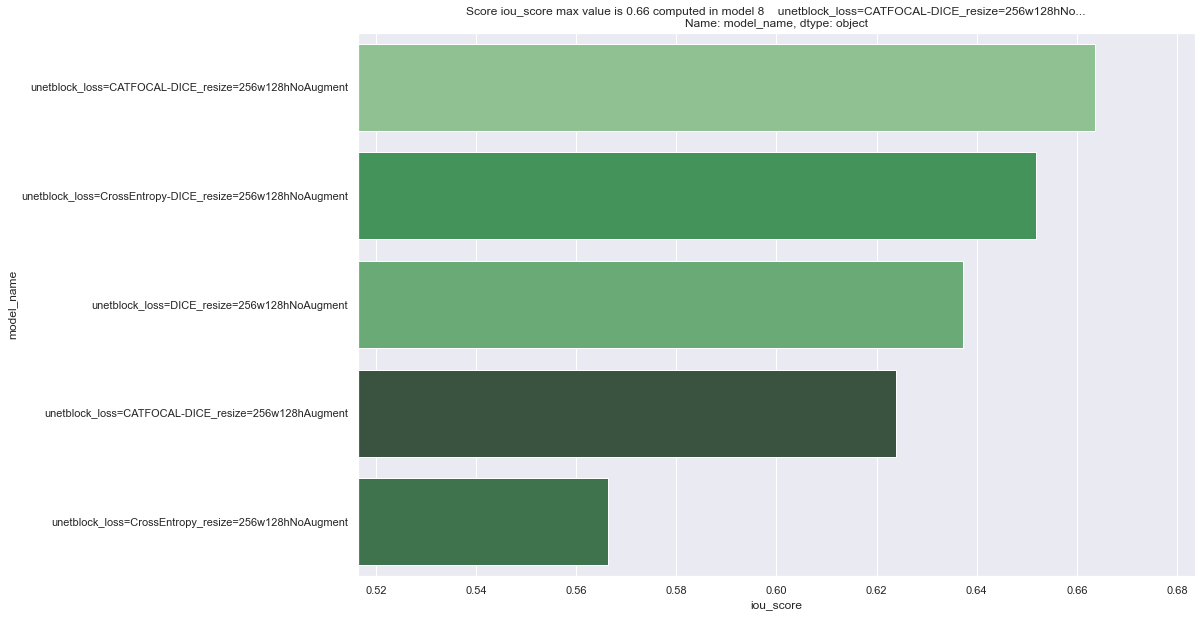

Le meilleur modèle obtient un IOU score de : [0.6635218262672424]
Le score final de la fonction de coût est de : [0.24607253074645996]


In [14]:
# IOU Score per model
plot_model_result(models_df.sort_values('iou_score', ascending=False).head(5), "iou_score", "model_name")
print("Le meilleur modèle obtient un IOU score de :",models_df.sort_values('iou_score', ascending=False).head(1)['iou_score'].values)
print("Le score final de la fonction de coût est de :",models_df.sort_values('iou_score', ascending=False).head(1)['loss'].values)

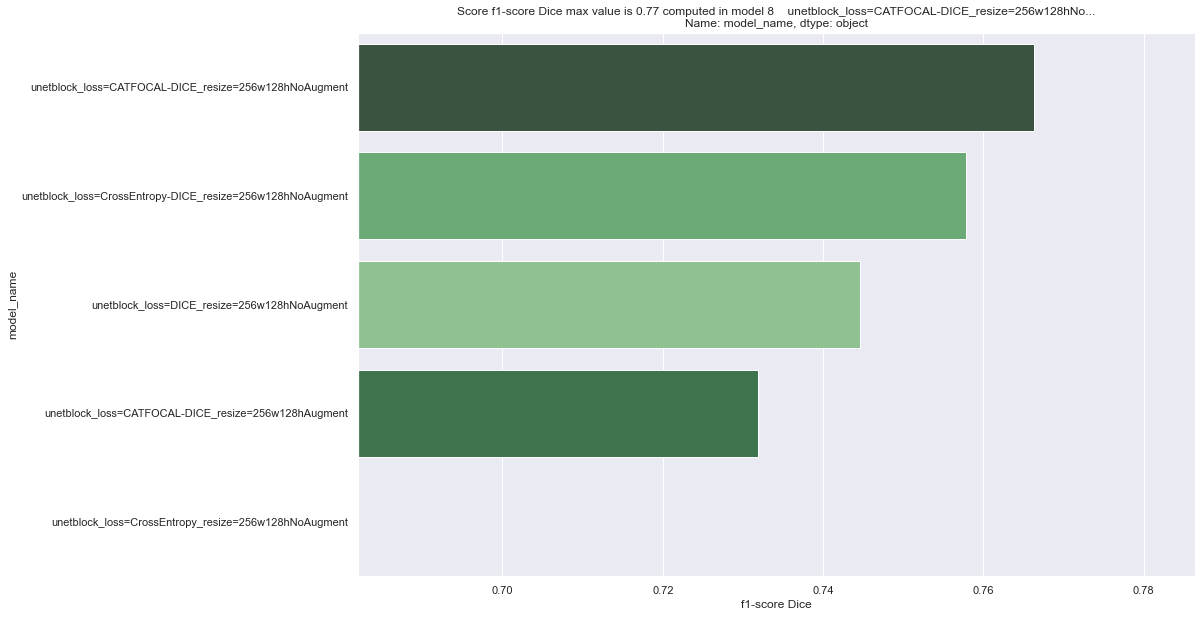

In [13]:
# DICE Score per model
plot_model_result(models_df.sort_values('iou_score', ascending=False).head(5), "f1-score Dice", "model_name")

In [24]:
#pairplot_columns(models_df.sort_values('iou_score', ascending=False).head(5), ['loss', 'f1-score Dice', 'iou_score'], False, 'model_loss')

In [21]:
#plot_boxplot(models_df, 'iou_score', ['model_loss', 'image_augmentation', 'width'], True)

In [25]:
#sns.catplot(data=(models_df.sort_values('iou_score', ascending=False).head(5)), kind="bar", x="model_loss", y="iou_score") #, hue="image_augmentation"

Au travers de ces évaluations, nous observons :
 - L'[augmentation d'images](https://albumentations.ai/docs/#introduction-to-image-augmentation) faites n'améliore pas les performances des modèles.
 - Les mesures DICE et IOU sont correlées
 - Le modèle le plus performant est entrainé avec une fonction de coût (0.5*CATFOCAL + DICE).

Nous conserverons cette fonction lors de l'entrainement de modèle suivant. 

Néanmoins, celui-ci pourrait certainement être encore amélioré par l'optimisation ddu facteur de 0.5 (Sensibilité accordé au CATFOCAL vs DICE).


## C. Autres Architectures

Nous allons ci-dessous divérsifier nos architectures, tels que:
 - UNET avec EfficientNet (Backbone)
 - UNET avec ResNet (Backbone)
 - [PSPNet](https://github.com/qubvel/segmentation_models/blob/master/segmentation_models/models/pspnet.py) - Pyramid Scene Parsing Network
 - [FPN](https://github.com/qubvel/segmentation_models/blob/master/segmentation_models/models/fpn.py)

Ici, nous allons utiliser les backbones contenant les poids pré-entrainés ([Voir Librairie](https://github.com/qubvel/segmentation_models)) sur le dataset ImageNet 2012 ILSVRC.

| Modèle | UNET | UNET EfficientNet | UNET RESNET | PSPNet | FPN |
|------------| ---- |-------|-------|-------------|--------|
| **Total params** | 7,760,328 | 14,296,314 | 24,457,169 |  1,986,562 | 10,822,906 |
| **Trainable params** | 7,760,328 | 14,226,762 | 24,439,819 | 1,975,794 | 10,753,034 |
| **Non-trainable params** | 0 | 69,552 | 17,350 | 10,768 | 69,872 |


In [15]:
# Data Loader preparation
n_sample = None #500 #Pour les tests, nous limitons le jeu de données à 20 images
batch_size = 5 #Pour les tests, nous limitons le batch_size à 2 images
resize_width = 256
resize_height = 128
# Declare an augmentation pipeline
augmentation = None 

# Generators
train_generators = GeneratorCitySpace(clean_df, n_sample, batch_size, resize_width, resize_height, 'train', augmentation)
val_generators = GeneratorCitySpace(clean_df, n_sample, batch_size, resize_width, resize_height, 'val', None)
val1_generators = GeneratorCitySpace(clean_df, n_sample, batch_size, 288, 144, 'val', None)
val2_generators = GeneratorCitySpace(clean_df, n_sample, 2, 512, 256, 'val', None)

test_generators = GeneratorCitySpace(clean_df, n_sample, 2, 512, 256, 'test', None)

In [16]:
# Define Metrics
metrics = [sm.metrics.FScore(), sm.metrics.IOUScore()] #Métriques = Choix final = Mesures de 2 métriques
# Define Loss function
loss_function = (0.5 * sm.losses.CategoricalFocalLoss()) + sm.losses.DiceLoss()
#loss_function = (0.5 * sm.losses.CategoricalCELoss()) + sm.losses.DiceLoss() 
# Define optimizer
learning_rate = 1e-4 #Nous reduisons le LR, afin d'éviter le surapprentissage, et les instabilité de la Loss
optim = keras.optimizers.Adam(learning_rate)

In [17]:
# callbacks that will be used during training
earlystopper = EarlyStopping(patience=10, verbose=1, mode = 'auto')
checkpoint = ModelCheckpoint(filepath = './Models/checkpoints/weights.h5', verbose=True, save_best_only=True, monitor='val_iou_score', mode='max')
reduce_lr = ReduceLROnPlateau(factor=0.1, cooldown= 10, patience=10, verbose=1, min_lr=1e-6)
n_epochs = 50

### 1. Modèle UNET avec BackBone ResNet34

In [27]:
# Define model
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)
model_unet_resnet = sm.Unet(BACKBONE, classes=8, activation='softmax', encoder_weights='imagenet') #input_shape=(None, None, 8)
# compile the model
model_unet_resnet.compile(optimizer=optim, loss=loss_function, metrics=metrics) 
# display the model summary
model_unet_resnet.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d[0][0]             
_______________________________________________________________________________________

In [28]:
#Train model
results = model_unet_resnet.fit(
                        train_generators, 
                        validation_data = val_generators, 
                        validation_steps = (len(clean_df.loc[clean_df['Phase'] == 'val']) // batch_size), #
                        steps_per_epoch = (len(clean_df.loc[clean_df['Phase'] == 'train']) // batch_size), #
                        epochs = n_epochs, 
                        workers=4,
                        verbose = 1,
                        #use_multiprocessing=True,
                        callbacks = [checkpoint, reduce_lr, earlystopper], #, reduce_lr
                        )

Epoch 1/50
595/595 [==============================] - ETA: 0s - loss: 0.5435 - f1-score: 0.4690 - iou_score: 0.3555WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0121s vs `on_test_batch_end` time: 0.0796s). Check your callbacks.

Epoch 00001: val_iou_score improved from -inf to 0.16642, saving model to ./Models/checkpoints\weights.h5
595/595 [==============================] - 94s 158ms/step - loss: 0.5435 - f1-score: 0.4690 - iou_score: 0.3555 - val_loss: 0.8031 - val_f1-score: 0.2304 - val_iou_score: 0.1664
Epoch 2/50
595/595 [==============================] - ETA: 0s - loss: 0.3778 - f1-score: 0.6351 - iou_score: 0.5163
Epoch 00002: val_iou_score improved from 0.16642 to 0.53311, saving model to ./Models/checkpoints\weights.h5
595/595 [==============================] - 115s 193ms/step - loss: 0.3778 - f1-score: 0.6351 - iou_score: 0.5163 - val_loss: 0.3615 - val_f1-score: 0.6517 - val_iou_score: 0.5331
Epoch 3/50
595/595 [===

In [29]:
# Save Trained Models
model_unet_resnet.save('./Models/unetresnet_Step3_CATFOCAL-DICE_IOU-DICE_model_256w_128h_1e-3lr_50epochs_Augment.h5')

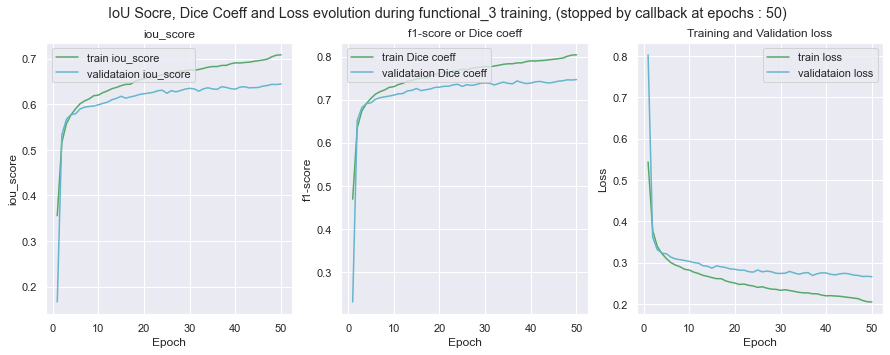

In [30]:
display_learning_curves_iou_dice(model_unet_resnet.history, model_unet_resnet.name) #measures iou and dice over epochs

### 2. Modèle UNET avec Backbone efficientNetb2

In [31]:
# Define model
BACKBONE = 'efficientnetb2'
preprocess_input = sm.get_preprocessing(BACKBONE)
model_unet_efficientnet = sm.Unet(BACKBONE, classes=8, activation='softmax', encoder_weights='imagenet')

# compile the model
model_unet_efficientnet.compile(optimizer=optim, loss=loss_function, metrics=metrics) 
# display the model summary
model_unet_efficientnet.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 3 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 3 0           stem_bn[0][0]                    
_______________________________________________________________________________________

In [32]:
#Train model
results = model_unet_efficientnet.fit(
                        train_generators, 
                        validation_data = val_generators, 
                        validation_steps = (len(clean_df.loc[clean_df['Phase'] == 'val']) // batch_size), #
                        steps_per_epoch = (len(clean_df.loc[clean_df['Phase'] == 'train']) // batch_size), #
                        epochs = n_epochs, 
                        workers=4,
                        verbose = 1,
                        #use_multiprocessing=True,
                        callbacks = [checkpoint, reduce_lr, earlystopper], #, reduce_lr
                        )

Epoch 1/50
595/595 [==============================] - ETA: 0s - loss: 0.7273 - f1-score: 0.2854 - iou_score: 0.1910WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0185s vs `on_test_batch_end` time: 0.0640s). Check your callbacks.

Epoch 00001: val_iou_score did not improve from 0.64443
595/595 [==============================] - 117s 197ms/step - loss: 0.7273 - f1-score: 0.2854 - iou_score: 0.1910 - val_loss: 0.6170 - val_f1-score: 0.3919 - val_iou_score: 0.2839
Epoch 2/50
595/595 [==============================] - ETA: 0s - loss: 0.5833 - f1-score: 0.4261 - iou_score: 0.3083
Epoch 00002: val_iou_score did not improve from 0.64443
595/595 [==============================] - 145s 244ms/step - loss: 0.5833 - f1-score: 0.4261 - iou_score: 0.3083 - val_loss: 0.5335 - val_f1-score: 0.4749 - val_iou_score: 0.3594
Epoch 3/50
595/595 [==============================] - ETA: 0s - loss: 0.5210 - f1-score: 0.4882 - iou_score: 0.3698
Epoch 000

In [ ]:
# Save Trained Models
model_unet_efficientnet.save('./Models/unetefficientnet_Step3_CATFOCAL-DICE_IOU-DICE_model_256w_128h_1e-3lr_50epochs_Augment.h5')

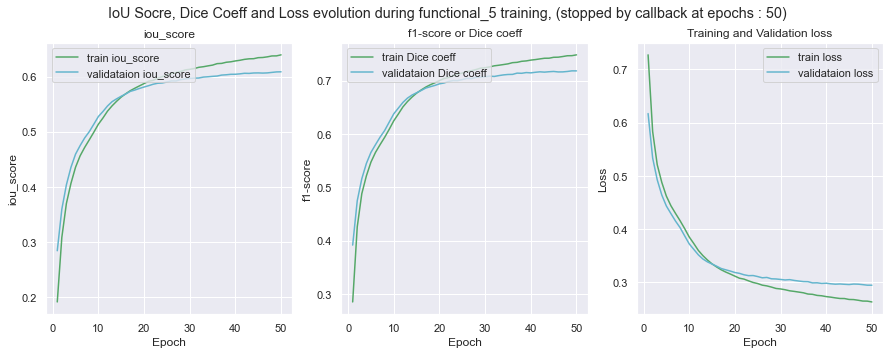

In [34]:
display_learning_curves_iou_dice(model_unet_efficientnet.history, model_unet_efficientnet.name) #measures iou and dice over epochs

### 3. Modèle PSPNet avec avec Backbone efficientNetb2

In [24]:
# Define model
BACKBONE = 'efficientnetb2'
preprocess_input = sm.get_preprocessing(BACKBONE)
model_pspnet_efficientnet = sm.PSPNet(BACKBONE, input_shape=(resize_height, resize_width, 3), classes=8, activation='softmax', encoder_weights='imagenet')

# compile the model
model_pspnet_efficientnet.compile(optimizer=optim, loss=loss_function, metrics=metrics) 
# display the model summary
model_pspnet_efficientnet.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 144, 288, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 72, 144, 32)  864         input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 72, 144, 32)  128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 72, 144, 32)  0           stem_bn[0][0]                    
_______________________________________________________________________________________

In [25]:
#Train model
results = model_pspnet_efficientnet.fit(
                        train_generators, 
                        validation_data = val_generators, 
                        validation_steps = (len(clean_df.loc[clean_df['Phase'] == 'val']) // batch_size), #
                        steps_per_epoch = (len(clean_df.loc[clean_df['Phase'] == 'train']) // batch_size), #
                        epochs = n_epochs, 
                        workers=4,
                        verbose = 1,
                        #use_multiprocessing=True,
                        callbacks = [checkpoint, reduce_lr, earlystopper], #, reduce_lr
                        )

Epoch 1/50
595/595 [==============================] - ETA: 0s - loss: 0.4633 - f1-score: 0.5862 - iou_score: 0.4654WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0168s vs `on_test_batch_end` time: 0.0386s). Check your callbacks.

Epoch 00001: val_iou_score improved from -inf to 0.50688, saving model to ./Models/checkpoints\weights.h5
595/595 [==============================] - 104s 176ms/step - loss: 0.4633 - f1-score: 0.5862 - iou_score: 0.4654 - val_loss: 0.4156 - val_f1-score: 0.6295 - val_iou_score: 0.5069
Epoch 2/50
595/595 [==============================] - ETA: 0s - loss: 0.3840 - f1-score: 0.6589 - iou_score: 0.5379
Epoch 00002: val_iou_score improved from 0.50688 to 0.52886, saving model to ./Models/checkpoints\weights.h5
595/595 [==============================] - 124s 209ms/step - loss: 0.3840 - f1-score: 0.6589 - iou_score: 0.5379 - val_loss: 0.3948 - val_f1-score: 0.6500 - val_iou_score: 0.5289
Epoch 3/50
595/595 [==

In [26]:
# Save Trained Models
model_pspnet_efficientnet.save('./Models/pspnetefficientnet_Step3_CrossEntropy-DICE_IOU-DICE_model_288w_144h_1e-3lr_50epochs_NoAugment.h5')

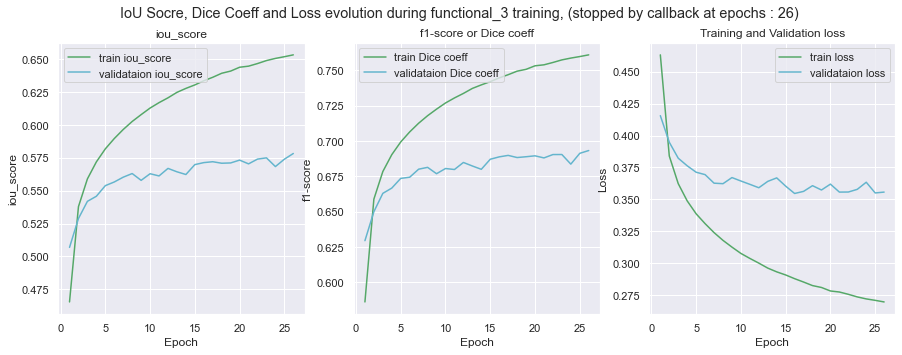

In [27]:
display_learning_curves_iou_dice(model_pspnet_efficientnet.history, model_pspnet_efficientnet.name) #measures iou and dice over epochs

### 4. Modèle FPN avec avec Backbone efficientNetb2

In [9]:
# Define model
BACKBONE = 'efficientnetb2'
preprocess_input = sm.get_preprocessing(BACKBONE)
model_fpn_efficientnet = sm.FPN(BACKBONE, classes=8, activation='softmax', encoder_weights='imagenet')

# compile the model
model_fpn_efficientnet.compile(optimizer=optim, loss=loss_function, metrics=metrics) 
# display the model summary
model_fpn_efficientnet.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 3 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 3 0           stem_bn[0][0]                    
_______________________________________________________________________________________

In [10]:
#Train model
results = model_fpn_efficientnet.fit(
                        train_generators, 
                        validation_data = val_generators, 
                        validation_steps = (len(clean_df.loc[clean_df['Phase'] == 'val']) // batch_size), #
                        steps_per_epoch = (len(clean_df.loc[clean_df['Phase'] == 'train']) // batch_size), #
                        epochs = n_epochs, 
                        workers=4,
                        verbose = 1,
                        #use_multiprocessing=True,
                        callbacks = [checkpoint, reduce_lr, earlystopper], #, reduce_lr
                        )

Epoch 1/50
1487/1487 [==============================] - ETA: 0s - loss: 0.3430 - f1-score: 0.6686 - iou_score: 0.5576WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0220s vs `on_test_batch_end` time: 0.1051s). Check your callbacks.

Epoch 00001: val_iou_score improved from -inf to 0.63166, saving model to ./Models/checkpoints\weights.h5
1487/1487 [==============================] - 558s 375ms/step - loss: 0.3430 - f1-score: 0.6686 - iou_score: 0.5576 - val_loss: 0.2784 - val_f1-score: 0.7328 - val_iou_score: 0.6317
Epoch 2/50
1487/1487 [==============================] - ETA: 0s - loss: 0.2772 - f1-score: 0.7334 - iou_score: 0.6292
Epoch 00002: val_iou_score improved from 0.63166 to 0.65488, saving model to ./Models/checkpoints\weights.h5
1487/1487 [==============================] - 586s 394ms/step - loss: 0.2772 - f1-score: 0.7334 - iou_score: 0.6292 - val_loss: 0.2575 - val_f1-score: 0.7528 - val_iou_score: 0.6549
Epoch 3/50
148

In [12]:
# Save Trained Models
model_fpn_efficientnet.save('./Models/fpnefficientnet_Step3_CATFOCAL-DICE_IOU-DICE_model_512w_256h_1e-3lr_50epochs_Augment.h5')

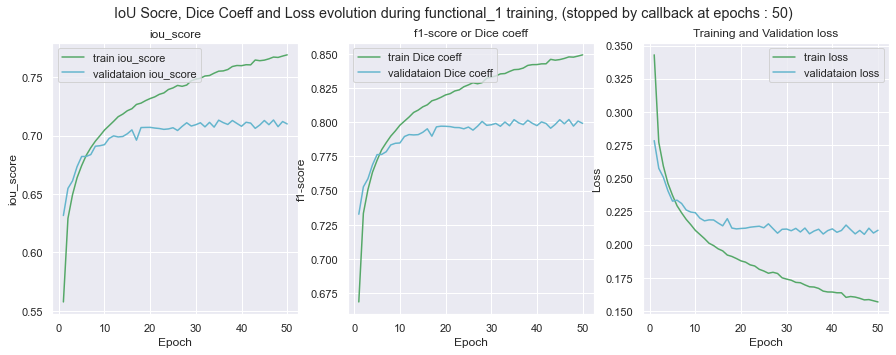

In [11]:
display_learning_curves_iou_dice(model_fpn_efficientnet.history, model_fpn_efficientnet.name) #measures iou and dice over epochs

### 5. Comparatif des résultats

In [18]:
# list to store files
Models_list = []
# Iterate directory
for file in os.listdir('./Models'):
    # check only h5 files
    if (file.endswith('.h5')) :
        #Append only the file name, whithout extension
        Models_list.append(file.split(".")[0])
#print(Models_list)


In [19]:
# Retreive root path from parent directory
src_path = os.path.abspath(os.path.join("../IA_Project8_Openclassrooms_VoitureAutonome"))
     
# define optimizer
learning_rate = 1e-3
optim = keras.optimizers.Adam(learning_rate)
# define metrics and losses dictionaires
dict_metrics = {'Accuracy': ['accuracy'], 'IOU-DICE': [sm.metrics.FScore(), sm.metrics.IOUScore()], 'IOU': [sm.metrics.IOUScore()], 'DICE': [sm.metrics.FScore()]}
dict_losses = {'CrossEntropy': sm.losses.CategoricalCELoss(), 'CATCELOSS': sm.losses.CategoricalCELoss(),'DICE': sm.losses.DiceLoss(), 'CrossEntropy-DICE': ((0.5 * sm.losses.CategoricalCELoss()) + sm.losses.DiceLoss()), 'JACCARD': sm.losses.JaccardLoss(),'CATFOCAL': sm.losses.CategoricalFocalLoss(), 'CATFOCAL-DICE': ((0.5 * sm.losses.CategoricalFocalLoss()) + sm.losses.DiceLoss()),'CrossEntropy-JACCARD': ((0.5 * sm.losses.CategoricalCELoss()) + sm.losses.JaccardLoss())}
# create empty dataframe, where model performance evaluation will be recorded
models_df = pd.DataFrame(columns=['model_name', 'model_loss', 'width', 'height', 'image_augmentation', 'loss', 'f1-score Dice', 'iou_score'])

# Loop in path listed from folder models (previous step)
for i in range(len(Models_list)):
    # Extract info from Name
    model_name = Models_list[i] + ".h5"
    print(model_name)
    model_loss = Models_list[i].split("_")[2]
    model_metrics = Models_list[i].split("_")[3]
    picture_width = Models_list[i].split("_")[5]
    picture_height = Models_list[i].split("_")[6]
    model_augment = Models_list[i].split("_")[9]
    # Consolidate  path name up to h5 model
    model_path_name = os.path.join(src_path, "Models", model_name)
    # Look in customized Dictionnary above to retreive loss functions and metrics
    loss_function = dict_losses[model_loss]
    metrics = dict_metrics[model_metrics]
    # Load  and Compile model (using loss functions and metrics)
    model = keras.models.load_model(model_path_name, compile=False) 
    model.compile(optimizer=optim, loss=loss_function, metrics=metrics) 
    # Evaluate model using Val dataset (as test dataset does not contain target values)
    if (picture_width == '256w'):
        results = model.evaluate(val_generators,verbose=0) 
    elif (picture_width == '288w'):  
        results = model.evaluate(val1_generators,verbose=0) 
    elif (picture_width == '512w'):  
        results = model.evaluate(val2_generators,verbose=0) 
    # Store results and info in dataframe models_df
    models_df.loc[i, 'model_name'] = model_name.split("_")[0] + "_loss=" + model_loss + "_resize=" + picture_width + picture_height + model_augment
    models_df.loc[i, 'model_loss'] = model_loss
    models_df.loc[i, 'width'] = picture_width
    models_df.loc[i, 'height'] = picture_height
    if (model_augment == 'Augment'):
        models_df.loc[i, 'image_augmentation'] = 'Yes'
    else:
        models_df.loc[i, 'image_augmentation'] = 'No'
    models_df.loc[i, 'loss'] = dict(zip(model.metrics_names, results))['loss']
    if (model_metrics.find('DICE') != -1):
        models_df.loc[i, 'f1-score Dice'] = dict(zip(model.metrics_names, results))['f1-score']
    else:
        models_df.loc[i, 'f1-score Dice'] = np.NaN
    if (model_metrics.find('IOU') != -1):
        models_df.loc[i, 'iou_score'] = dict(zip(model.metrics_names, results))['iou_score']
    else:
        models_df.loc[i, 'iou_score'] = np.NaN


fpnefficientnet_Step3_CATFOCAL-DICE_IOU-DICE_model_256w_128h_1e-3lr_50epochs_Augment.h5
fpnefficientnet_Step3_CATFOCAL-DICE_IOU-DICE_model_256w_128h_1e-3lr_50epochs_NoAugment.h5
fpnefficientnet_Step3_CATFOCAL-DICE_IOU-DICE_model_512w_256h_1e-3lr_50epochs_Augment.h5
fpnefficientnet_Step3_CATFOCAL-DICE_IOU-DICE_model_512w_256h_1e-3lr_50epochs_NoAugment.h5
fpnefficientnet_Step3_CrossEntropy-DICE_IOU-DICE_model_256w_128h_1e-3lr_50epochs_Augment.h5
fpnefficientnet_Step3_CrossEntropy-DICE_IOU-DICE_model_256w_128h_1e-3lr_50epochs_NoAugment.h5
pspnetefficientnet_Step3_CATFOCAL-DICE_IOU-DICE_model_288w_144h_1e-3lr_50epochs_NoAugment.h5
pspnetefficientnet_Step3_CrossEntropy-DICE_IOU-DICE_model_288w_144h_1e-3lr_50epochs_NoAugment.h5
unetblock_Step1_CrossEntropy_Accuracy_model_256w_128h_1e-3lr_50epochs_NoAugment.h5
unetblock_Step1_CrossEntropy_IOU-DICE_model_256w_128h_1e-3lr_50epochs_Augment.h5
unetblock_Step1_CrossEntropy_IOU-DICE_model_256w_128h_1e-3lr_50epochs_NoAugment.h5
unetblock_Step2_CATFO

In [21]:
#models_df.sort_values('iou_score', ascending=False).head(10)
#models_df.loc[models_df['image_augmentation'] == 'Yes', :].sort_values('iou_score', ascending=False)
models_df.loc[(models_df['model_name'].str.contains("block") & models_df['width'].str.contains("256w")), :].sort_values('iou_score', ascending=False).head(5)
models_df.loc[models_df['width'].str.contains("256w"), :].sort_values('iou_score', ascending=False).head(5)
models_df.sort_values('iou_score', ascending=False).head(8)

,model_name,model_loss,width,height,image_augmentation,loss,f1-score Dice,iou_score
3,fpnefficientnet_loss=CATFOCAL-DICE_resize=512w...,CATFOCAL-DICE,512w,256h,No,0.209923,0.801264,0.713473
2,fpnefficientnet_loss=CATFOCAL-DICE_resize=512w...,CATFOCAL-DICE,512w,256h,Yes,0.210838,0.799204,0.710077
24,unetefficientnet_loss=CATFOCAL-DICE_resize=512...,CATFOCAL-DICE,512w,256h,No,0.216064,0.795011,0.706814
0,fpnefficientnet_loss=CATFOCAL-DICE_resize=256w...,CATFOCAL-DICE,256w,128h,Yes,0.245399,0.767559,0.666621
1,fpnefficientnet_loss=CATFOCAL-DICE_resize=256w...,CATFOCAL-DICE,256w,128h,No,0.255883,0.759955,0.658755
4,fpnefficientnet_loss=CrossEntropy-DICE_resize=...,CrossEntropy-DICE,256w,128h,Yes,0.281678,0.76109,0.657359
18,unetblock_loss=CrossEntropy-DICE_resize=256w12...,CrossEntropy-DICE,256w,128h,No,0.276183,0.757887,0.651876
23,unetefficientnet_loss=CATFOCAL-DICE_resize=256...,CATFOCAL-DICE,256w,128h,No,0.260546,0.753423,0.651549


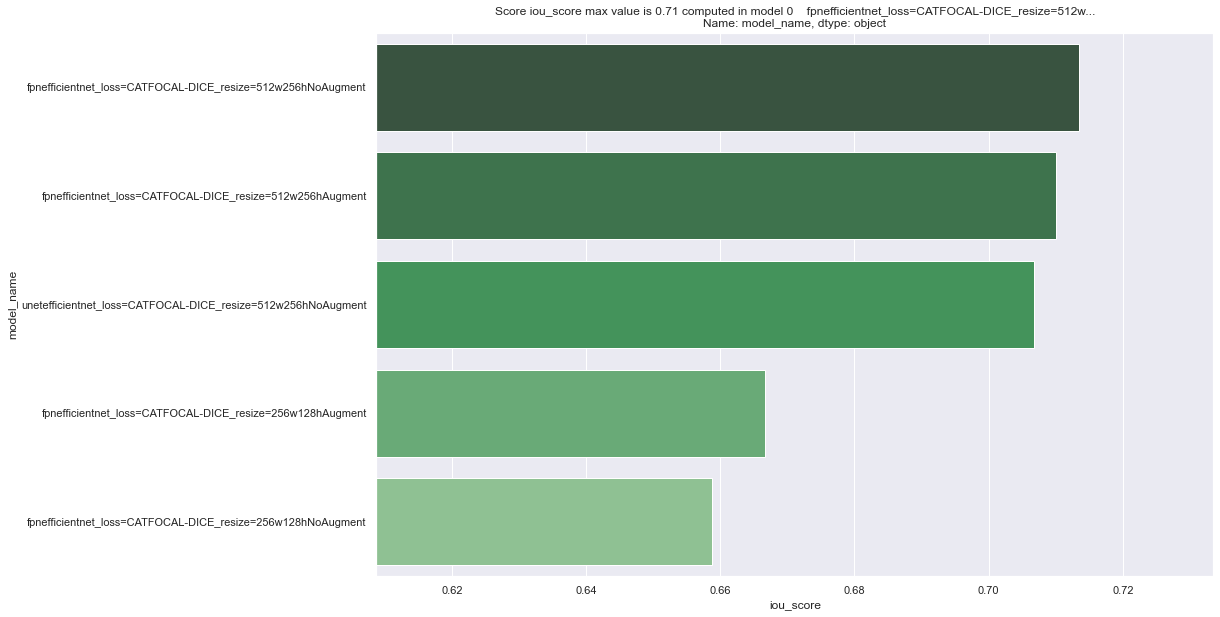

Le meilleur modèle obtient un IOU score de : [0.7134732604026794]
Le score final de la fonction de coût est de : [0.20992335677146912]


In [22]:
# IOU Score per model
plot_model_result(models_df.sort_values('iou_score', ascending=False).head(5).reset_index(), "iou_score", "model_name")
print("Le meilleur modèle obtient un IOU score de :",models_df.sort_values('iou_score', ascending=False).head(1)['iou_score'].values)
print("Le score final de la fonction de coût est de :",models_df.sort_values('iou_score', ascending=False).head(1)['loss'].values)

## D. Visualisation avec le meilleur modèle

In [5]:
src_path = os.path.abspath(os.path.join("../IA_Project8_Openclassrooms_VoitureAutonome"))
#model_name = 'unetblock_Step3_Crossentropy-DICE_IOU-DICE_model_256w_128h_1e-3lr_50epochs_NoAugment.h5' 
#model_name = 'fpnefficientnet_Step3_CATFOCAL-DICE_IOU-DICE_model_256w_128h_1e-3lr_50epochs_NoAugment.h5'
model_name = 'fpnefficientnet_Step3_CATFOCAL-DICE_IOU-DICE_model_512w_256h_1e-3lr_50epochs_NoAugment.h5'

# Consolidate  path name up to h5 model
model_path_name = os.path.join(src_path, "Models", model_name)

# Load best model
final_model = keras.models.load_model(model_path_name, compile=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


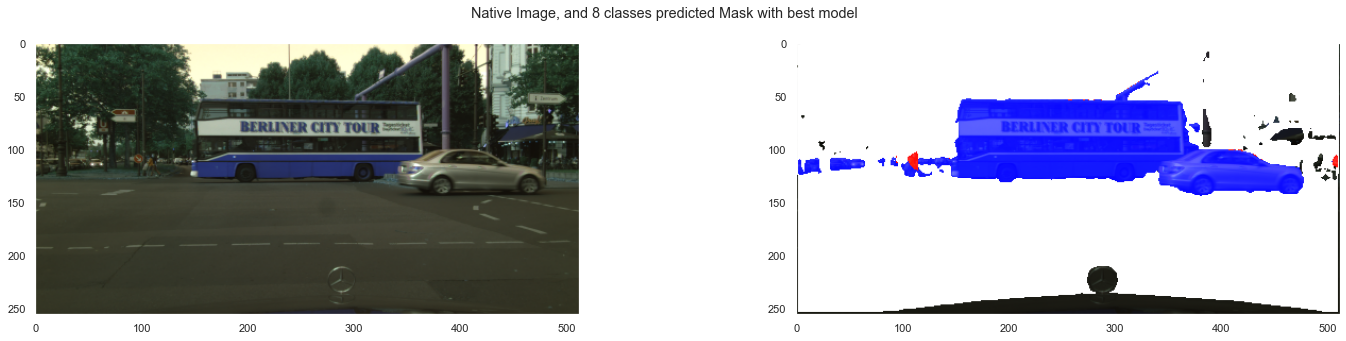

In [63]:
color_map = {
    '0': [0,0,0],
    '1': [128,64,128],
    '2': [70,70,70],
    '3': [250,170,30],
    '4': [107,142,35],
    '5': [70,130,180],
    '6': [255,0,0],
    '7': [0,0,255]
    }

# Select batch id and picture id from batch
picture_id = 1
batch_id = 5
alpha = 0.5

image = test_generators[batch_id][0][picture_id]
x = np.expand_dims(image, axis=0)
# Use test dataset to generate masks from batch_generator images, using trained model
masks = final_model.predict(test_generators[batch_id]) 
# Convert One hot encoded mask, to int from 0 to 7
y = np.argmax(masks[picture_id], axis=2) #.astype(np.uint8)
#print(y.unique())
# y = np.argmax(z, axis=2)
mask = image.copy()   
for i in range(0, mask.shape[0]): 
    for j in range(0, mask.shape[1]):
        mask[i,j] = color_map[str(y[i, j])]
mask = cv2.addWeighted(image, alpha, mask, 1-alpha, 0, mask)


plt.figure(figsize=(25, 5))
plt.subplots_adjust(hspace=0.5)
plt.subplot(120 + 1 + 0)
plt.grid(False)
plt.imshow(image)
plt.subplot(120 + 1 + 1)
plt.imshow(mask)
plt.grid(False)
plt.suptitle(f'Native Image, and 8 classes predicted Mask with best model')
plt.show()


In [12]:
color_map = {
    '0': [0,0,0],
    '1': [128,64,128],
    '2': [70,70,70],
    '3': [250,170,30],
    '4': [107,142,35],
    '5': [70,130,180],
    '6': [255,0,0],
    '7': [0,0,255]
    }

def predict_display_mask(image):
    alpha = 0.5
    dims = image.shape
    print(dims)
    w = cv2.resize(image, (512, 256))
    w = w/255
    x = np.expand_dims(w, axis=0)
    z = final_model.predict(x) 
    z = z[0]
    z = cv2.resize(z, (dims[1], dims[0]))
    y = np.argmax(z, axis=2)
    
    mask = image.copy()   
    for i in range(dims[0]):
        for j in range(dims[1]):
            mask[i, j] = color_map[str(y[i, j])]
    mask = cv2.addWeighted(image, alpha, mask, 1-alpha, 0, mask)
    return mask

(1024, 2048, 3)


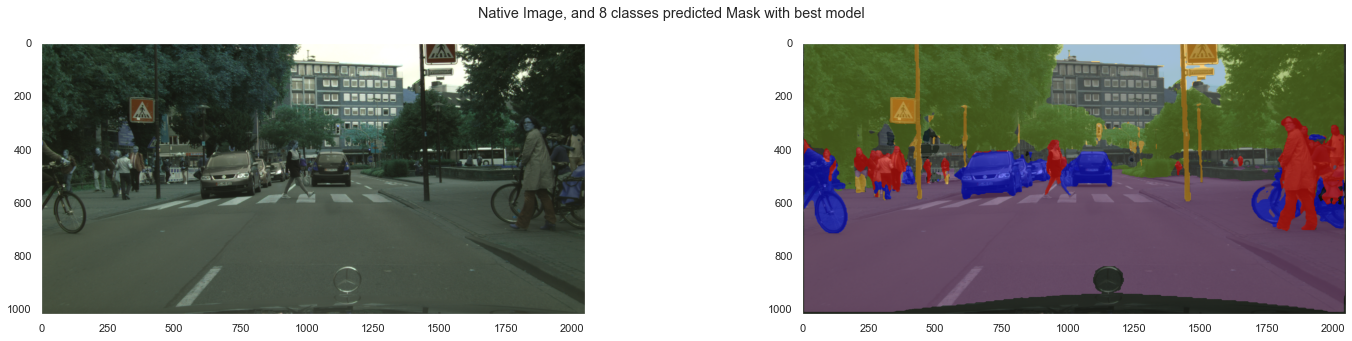

In [14]:
image_file_path = os.path.join(src_path, "Dataset", "P8_Cityscapes_leftImg8bit_trainvaltest", "leftImg8bit", "val", "munster", "munster_000048_000019_leftImg8bit.png")
image = cv2.imread(image_file_path)
#image = cv2.resize(image, (512, 256))
mask = predict_display_mask(image)
plt.figure(figsize=(25, 5))
plt.subplots_adjust(hspace=0.5)
plt.subplot(120 + 1 + 0)
plt.grid(False)
plt.imshow(image)
plt.subplot(120 + 1 + 1)
plt.imshow(mask)
plt.grid(False)
plt.suptitle(f'Native Image, and 8 classes predicted Mask with best model')
plt.show()